<a href="https://colab.research.google.com/github/snymanje/MultiClass-Text-Classification/blob/master/MultiClass_Text_Classification_with_Multiple_Estimators_and_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Evaluating multiple models ( Customer Complaints Classification )**

### **Get the data ready**

As an example dataset, we'll import Consumer_Complaints.csv.

In [35]:
# Import data and filter only on the needed features an labels
import pandas as pd
import numpy as np

dataset = pd.read_csv('drive/My Drive/Colab Notebooks/Consumer_Complaints.csv')

# Select only the Product and Consumer Complaint columns  
col = ['Product', 'Consumer Complaint']
dataset= dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["Consumer Complaint"], inplace=True)

# Rename column
dataset.columns=['Product', 'ConsumerComplaint'] 

# Convert the label (Product) to numeric using the pd factorize function 
dataset['category_id'] = dataset['Product'].factorize()[0]

# Only include the following products
dataset=dataset[dataset['Product'].isin(['Credit reporting', 'Debt collection', 'Mortgage', 'Credit Card','Student loan','Bank account or service'])]

# Print the top 5 rows
dataset.head()

,Product,ConsumerComplaint,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2
25,Mortgage,Started the refinance of home mortgage process...,3


#### **How clean is the text?**

In [17]:
dataset["ConsumerComplaint"].to_list()[:2]

['I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements',
 'An account on my credit report has a mistaken date. I mailed in a debt validation letter to allow XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be " suspicious \'\' and that " I did n\'t write it \'\'. Experian \'s letter is worded to imply that I am incapable of writing my own letter. I was deeply offended by this implication. \nI called Experian to figure out why my letter was so suspicious. I spoke to a representative who was incredibly unhelpful, She did not effectively answer any questions I asked of her, and she kept ignoring what I was saying regarding the offensive letter and my dispute process. I feel the representative did what she wanted to do, and I am not satisfied. It is STILL not clea

#### **Run data through cleanup function**

In [18]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace('x', '') # Remove the XXXX values
    text = REMOVE_NUM.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **How clean is the text now?**

In [19]:
dataset["ConsumerComplaint"].to_list()[:5]

['outdated information credit report previously disputed yet removed information seven years old meet credit reporting requirements',
 'account credit report mistaken date mailed debt validation letter allow correct information received letter mail stating eperian received correspondence found suspicious nt write eperian letter worded imply incapable writing letter deeply offended implication called eperian figure letter suspicious spoke representative incredibly unhelpful effectively answer questions asked kept ignoring saying regarding offensive letter dispute process feel representative wanted satisfied still clear received letter typed letter signed letter paid mail letter yet eperian willfully disregarded lawful request disgusted entire situation would like dispute handled appropriately would like eperian representative contact give real eplanation letter',
 'company refuses provide verification validation debt per right fdcpa believe debt mine',
 'complaint regards square two fin

In [20]:
dataset.head()

,Product,ConsumerComplaint,category_id
1,Credit reporting,outdated information credit report previously ...,0
7,Credit reporting,account credit report mistaken date mailed deb...,0
12,Debt collection,company refuses provide verification validatio...,2
16,Debt collection,complaint regards square two financial refer c...,2
25,Mortgage,started refinance home mortgage process cash o...,3


### Plot the data

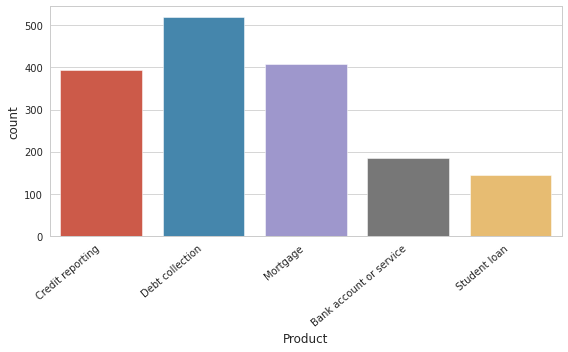

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [22]:
# Shuffel the dataset
dataset = dataset.sample(frac=1)
dataset.head()

,Product,ConsumerComplaint,category_id
4982,Debt collection,left multiple vocie message advising serving l...,2
4272,Debt collection,went another cell carrier received invoice pay...,2
6500,Bank account or service,presented check chase mobile deposit received ...,6
9597,Credit reporting,transunion credit report service following acc...,0
3457,Debt collection,trans world systems contacted regarding debts ...,2


### Split the data into training and test sets

In [0]:
# Split into X/y
from sklearn.model_selection import train_test_split, cross_val_score

x = dataset["ConsumerComplaint"]
y = dataset["category_id"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### **Convert text features to numeric**

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
cv2 = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')

X_traincv = cv2.fit_transform(x_train)
x_testcv = cv2.transform(x_test)
print(X_traincv.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.16996648 0.         ... 0.         0.         0.        ]]


### **Build the model with the best estimator**

In [25]:
# Hyperparameter grid RandomizedSearchCV will search over

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ignore ConvergenceWarnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

models = [
    { "estimater": KNeighborsClassifier(),
      "params": {
          "n_neighbors": [25,30,35,45],
          "weights": ['uniform','distance'],
          "leaf_size": [25,30,35]
        }
    },
    { "estimater": DecisionTreeClassifier(),
      "params": {
          "criterion": ['gini','entropy'],
          "splitter": ['best','random'],
          "max_depth": [None,90,95,100],
          "max_features": [None, "auto","sqrt","log2"],
          "random_state": [42]
      }
    },
    { "estimater": MultinomialNB(),
      "params": {
          "fit_prior": [True, False]    
      }
    },
    { "estimater": LinearSVC(),
      "params": {
          "loss": ['hinge','squared_hinge'],
          "multi_class": ['ovr', 'crammer_singer'],
          "fit_intercept": [True, False],
          "random_state": [42],
          "max_iter": [900, 1000, 1100]
      }
    },
    { "estimater": svm.SVC(),
      "params": {
          'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']
      }
    },
    { "estimater": RandomForestClassifier(),
      "params": {
      "criterion": ['gini','entropy'],
      "bootstrap": [True, False],
      "max_depth": [85,90,95,100],
      "max_features": ['sqrt','log2'],
      "n_estimators": [60, 80, 90],
      "random_state": [42]
      }
    },
    { "estimater": SGDClassifier(),
      "params": {
          "loss": ['hinge','log','perceptron'], 
          "penalty": ['l2', 'l1'], 
          "alpha": [0.0001, 0.0003, 0.0010],
          "early_stopping": [True],
          "max_iter": [1000, 1500],
          "random_state": [42]
      }
    }
]

column_names = ["KNeighbors", "DecisionTree", "MultiNB", "SVC", "SVM", "RFC", "SGDClassifier"]
entries = []

highest_acc = 0
best_model = None

for model in models:
  print(model["estimater"])

  # Create a based model
  clf = model["estimater"]
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf, param_grid = model["params"], 
                            cv = 3, n_jobs = 1)
  # Fit the model
  grid_search.fit(X_traincv, y_train);

  # Make a prediction on the test split to find model accuracy
  predicted = grid_search.predict(x_testcv)
  acc = accuracy_score(predicted, y_test)
  entries.append(acc)

  print(grid_search.best_params_)

  # If model have the highest accuracy, it's out best model
  if acc > highest_acc:
    highest_acc = acc
    best_model = grid_search

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
{'leaf_size': 25, 'n_neighbors': 45, 'weights': 'distance'}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'random_state': 42, 'splitter': 'best'}
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
{'fit_prior': False}
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     

       Estimater  Accuracy
0     KNeighbors  0.845921
1   DecisionTree  0.740181
2        MultiNB  0.861027
3            SVC  0.888218
4            SVM  0.864048
5            RFC  0.833837
6  SGDClassifier  0.870091


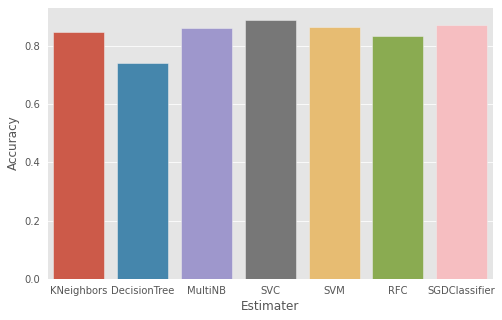

In [36]:
# Plotting each models performance

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 5))

df = pd.DataFrame({"Estimater": column_names, 
                   "Accuracy": entries
                  })

sns.barplot(x='Estimater', y='Accuracy', data=df)

print(df)

In [27]:
# Use best estimater to build a model for predictions
print(best_model.predict(x_testcv))
print(best_model.score(x_testcv, y_test))

[0 3 0 2 2 2 2 2 6 3 0 6 2 2 0 0 3 3 0 0 0 2 6 3 3 0 3 0 0 2 2 3 0 6 6 2 2
 6 0 2 2 6 0 2 7 2 7 2 2 2 6 3 6 6 0 3 0 0 2 3 2 0 3 2 2 3 3 3 6 6 3 3 3 2
 2 0 2 7 0 3 2 0 2 0 3 2 2 0 2 3 6 3 3 2 2 3 2 2 2 6 3 2 0 7 0 2 3 3 2 2 3
 2 2 2 3 2 2 7 2 3 7 2 0 0 3 0 2 2 7 2 3 2 0 3 6 3 3 3 3 6 3 7 3 0 2 0 6 0
 0 0 0 2 3 3 2 6 3 0 3 2 0 3 2 0 3 0 2 3 7 7 2 6 2 2 3 3 3 0 3 0 2 7 2 2 2
 6 3 6 2 0 2 3 0 0 3 3 0 3 2 6 6 0 6 3 2 0 3 2 2 0 2 0 3 7 6 2 2 2 2 7 3 2
 3 7 2 0 2 3 3 2 0 3 3 2 0 6 2 0 6 2 3 2 0 2 2 3 3 2 6 2 2 2 2 0 3 3 0 0 2
 0 0 0 0 3 6 2 3 0 0 0 3 0 2 2 2 2 2 6 0 3 6 7 3 2 0 2 2 0 2 3 2 0 0 2 2 3
 0 7 0 2 2 6 2 0 2 0 3 3 0 6 2 7 2 6 0 6 3 2 6 6 0 0 3 3 6 7 3 2 3 3 0]
0.8882175226586103


In [28]:
dataset.head(10)

,Product,ConsumerComplaint,category_id
4982,Debt collection,left multiple vocie message advising serving l...,2
4272,Debt collection,went another cell carrier received invoice pay...,2
6500,Bank account or service,presented check chase mobile deposit received ...,6
9597,Credit reporting,transunion credit report service following acc...,0
3457,Debt collection,trans world systems contacted regarding debts ...,2
6129,Debt collection,eempt federal laws protecting veterans company...,2
8334,Mortgage,home foreclosed sold via short sale green tree...,3
4542,Debt collection,correspondence construed way agreeing admittin...,2
6009,Debt collection,calls within hours snapshot calls phone sister...,2
3519,Student loan,currently repaying student loan american educa...,7


### Evaluation metrics

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [30]:
predicted = best_model.predict(x_testcv)
evaluate_preds(y_test, predicted)

Acc: 88.82%
Precision: 0.89
Recall: 0.89
F1 score: 0.89


{'accuracy': 0.89, 'f1': 0.89, 'precision': 0.89, 'recall': 0.89}

In [31]:
uniques = dataset.drop('ConsumerComplaint', axis=1)
unique_labels = uniques.drop_duplicates()
unique_labels

,Product,category_id
4982,Debt collection,2
6500,Bank account or service,6
9597,Credit reporting,0
8334,Mortgage,3
3519,Student loan,7


In [32]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted, 
                                    target_names=dataset['Product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.84      0.90      0.87        73
Bank account or service       0.88      0.90      0.89       110
       Credit reporting       0.90      0.96      0.93        79
               Mortgage       0.95      0.84      0.89        43
           Student loan       0.94      0.65      0.77        26

               accuracy                           0.89       331
              macro avg       0.90      0.85      0.87       331
           weighted avg       0.89      0.89      0.89       331



* ***Accuracy*** is a good measure to start with if all classes are balanced (e.g. same amount of samples which are labelled with 0 or 1).
* ***Precision*** and ***recall*** become more important when classes are imbalanced.
If false positive predictions are worse than false negatives, aim for higher precision.
If false negative predictions are worse than false positives, aim for higher recall.
* ***F1-score*** is a combination of precision and recall.

In [33]:
# Visualize confusion matrix with pd.crosstab()
pd.crosstab(y_test,
            predicted,
            rownames=["Actual Labels"],
            colnames=["Predicted Labels"])

Predicted Labels,0,2,3,6,7
Actual Labels,,,,,
0,66,5,0,1,1
2,6,99,4,1,0
3,3,0,76,0,0
6,1,4,2,36,0
7,3,4,2,0,17


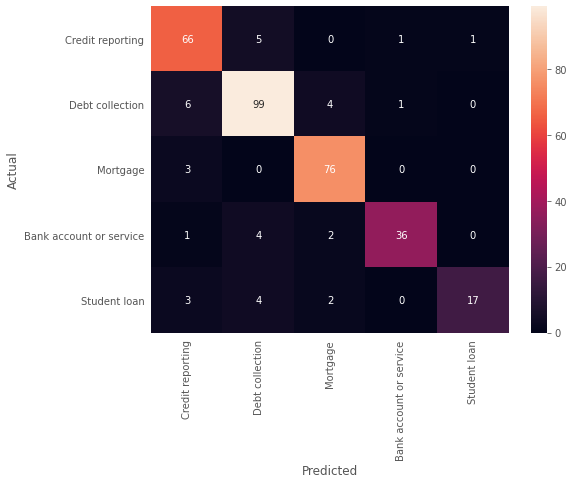

In [37]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [40]:
uniques = dataset.drop('ConsumerComplaint', axis=1)
unique_labels = uniques.drop_duplicates()
unique_labels

,Product,category_id
1,Credit reporting,0
12,Debt collection,2
25,Mortgage,3
124,Bank account or service,6
152,Student loan,7


In [44]:
inputStr = cv2.transform(["I need to finance my student loan please"])
results = best_model.predict(inputStr )

print(f'Product category id: {results[0]}')
print(f'Product Name: { np.asarray(unique_labels[unique_labels.category_id.eq(results[0])])[0][0] }')
print(f'Accuracy score: { acc.max() * 100}')

Product category id: 7
Product Name: Student loan
Accuracy score: 87.00906344410876
